In [1]:
import preprocessing as pp
import data2D3D
import os
import glob
import numpy as np
import logging
import nibabel as nib
import gc
from skimage import transform
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import tensorflow as tf
from torch.utils.data import SubsetRandomSampler
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import random
import pickle
import sys
%matplotlib inline
get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pyplot as plt
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from torch.utils import data as D
from torch import nn
from torch.nn import functional as F
from torchvision import models
import torch.optim as optim
from time import time
from data2D3D import data2D3D
from D_UNet import U_Net


logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')
nx=224;
img_T, mask_T, imageSS, num=pp.data_prepare(norm=False)


In [2]:
path = 'datacollect'    
tumor_dataset = data2D3D(path, imageSS, img_T, mask_T, num, nx, aug=True)
test_indices=list(range(1410, 1502))

test_sampler=torch.utils.data.SequentialSampler(test_indices)
testloader = torch.utils.data.DataLoader(tumor_dataset, 1,num_workers=0, sampler=test_sampler, shuffle=False )


number=141
train_indices=list(range(0,141*9))
validation_indices=list(range(141*9,1410))
train_sampler, validation_sampler = SubsetRandomSampler(train_indices), SubsetRandomSampler(validation_indices)
trainloaderlibrary=[]
validationloaderlibrary=[]
trainloaderlibrary.append(torch.utils.data.DataLoader(tumor_dataset, 5, num_workers=0, sampler=train_sampler))
validationloaderlibrary.append(torch.utils.data.DataLoader(tumor_dataset, 5, sampler=validation_sampler))
for i in range (1,10):
    train_indices=list(range(number*i,1410))
    train_indices.extend (range(0,number*(i-1)))
    validation_indices = list(range(number*(i-1),number*i))
    train_sampler, validation_sampler = SubsetRandomSampler(train_indices), SubsetRandomSampler(validation_indices)
    trainloader = torch.utils.data.DataLoader(tumor_dataset, 5, num_workers=0, sampler=train_sampler)
    validationloader = torch.utils.data.DataLoader(tumor_dataset, 5, sampler=validation_sampler)
    trainloaderlibrary.append(trainloader)
    validationloaderlibrary.append(validationloader)
  

In [3]:
def dice_loss(true, logits, eps=1e-7):
    true_1_hot = torch.eye(4)[true.squeeze(1).type(torch.long)]
    true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
    probas = F.softmax(logits, dim=1)
    true_1_hot = true_1_hot.type(logits.type())
    dims = (0,) + tuple(range(2, true.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims)
    cardinality = torch.sum(probas + true_1_hot, dims)
    dice_loss = (2. * intersection / (cardinality + eps)).mean()
    return (1 - dice_loss)


In [4]:
model_save_path = './saved_models/Mix/'
os.makedirs(model_save_path, exist_ok = True)
unet_classifier = None
learning_rate = 0.0001  #0.0001
learning_rate = 8e-07 
mini_batch = False
unet_model = U_Net().to(device)

history = {'train_loss': list(), 'validation_loss': list()}

# For save best feature. Initial loss taken a very high value.
last_score = 0

# Optimizer used for training process. Adam Optimizer.
optimizer = optim.Adam(unet_model.parameters(), lr = learning_rate)

# Reducing LR on plateau feature to improve training.
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.85, patience = 2, verbose = True)

print('Starting Training Process')
criterion=nn.CrossEntropyLoss(weight=torch.tensor([0.1, 0.3, 0.3, 0.3]).to(device))
epochs=500

for epoch in range(epochs):
    
    #################################### Train ####################################################
    unet_model.train()
    start_time = time()
    # Training a single epoch
    train_epoch_loss, train_batch_loss, batch_iteration = 0, 0, 0
    validation_score, validation_loss = 0, 0
    trainloader=trainloaderlibrary[epoch%10]
    validationloader=validationloaderlibrary[epoch%10]
    

    for batch, data in enumerate(trainloader):
        # Keeping track how many iteration is happening.
        batch_iteration += 1
        # Loading data to device used.
        image = data['image2D'].to(device)
        image3D = data['image3D'].to(device)
        mask = data['mask2D'].to(device)
        
        #image = data['image2D']
        #image3D = data['image3D']
        #mask = data['mask2D']
        
        # Clearing gradients of optimizer.
        optimizer.zero_grad()
        # Calculation predicted output using forward pass.
        
        output = unet_model(image.cuda(), image3D.cuda()).type(torch.float)

        # Calculating the loss value.

        loss_value = criterion(output*3, mask.squeeze(1).type(torch.long))+dice_loss(mask,output*3)
        
        
        # Computing the gradients.
        loss_value.backward()
        # Optimizing the network parameters.
        optimizer.step()
        # Updating the running training loss
        train_epoch_loss += loss_value.item()
        train_batch_loss += loss_value.item()
        # Printing batch logs if any. Useful if you want to see the training trends within each epoch.
        if mini_batch:
            if (batch + 1) % mini_batch == 0:
                train_batch_loss = train_batch_loss / (mini_batch * trainloader.batch_size)
                print(
                    f'    Batch: {batch + 1:2d},\tBatch Loss: {train_batch_loss:.7f}')
                train_batch_loss = 0
    train_epoch_loss = train_epoch_loss / (batch_iteration * trainloader.batch_size)

    

    ################################### Validation ##################################################
    unet_model.eval()
    # To get data in loops.
    batch_iteration = 0
    
    

    for batch, data in enumerate(validationloader):
        # Keeping track how many iteration is happening.
        batch_iteration += 1
        # Data prepared to be given as input to model.
        image = data['image2D'].type(torch.float).to(device)
        image3D = data['image3D'].type(torch.float).to(device)
        mask = data['mask2D'].type(torch.float).to(device)
        
        # Predicted output from the input sample.
        mask_prediction = unet_model(image.cuda(), image3D.cuda()).type(torch.float)
        
        #loss_value = criterion(mask_prediction.to(device), mask)
        loss_value = criterion(mask_prediction*3, mask.squeeze(1).type(torch.long))+dice_loss(mask,mask_prediction*3)
        
        #loss_value = dice_loss(mask,mask_prediction*3)
        validation_loss += loss_value.item()

    # Calculating the mean score for the whole validation dataset.
    validation_loss = validation_loss / batch_iteration
    
    # Collecting all epoch loss values for future visualization.
    history['train_loss'].append(train_epoch_loss)
    history['validation_loss'].append(validation_loss)
    
    # Reduce LR On Plateau
    scheduler.step(validation_loss)

    time_taken = time() - start_time
    
    # Training Logs printed.
    print(f'Epoch: {epoch + 1:3d},  ', end = '')
    print(f'train Loss: {train_epoch_loss:.5f},  ', end = '')
    print(f'validation Loss: {validation_loss:.5f},  ', end = '')


    for pg in optimizer.param_groups:
        print('current lr: ', pg['lr'], ', ', end = '')
    print(f'Time: {time_taken:.2f} s')

    # Save the model every epoch.
    current_epoch_model_save_path = os.path.join(model_save_path, 'Basic_Unet_epoch_%s.pth' % (str(epoch).zfill(3)))
    torch.save(unet_model.state_dict(), current_epoch_model_save_path)  

print(f'Training Finished after {epochs} epoches')

Starting Training Process
Epoch:   1,  train Loss: 0.45895,  validation Loss: 2.22467,  current lr:  8e-07 , Time: 88.38 s


KeyboardInterrupt: 

In [ ]:
pp.history_plot(history)

In [5]:
best_epoch=96;
# Load the unet model at its prime (when it performed the best on the validation set).
# best_epoch = np.argmin(history['validation_loss'])
print('best epoch: ', best_epoch)
unet_model = U_Net().to(device)

state_dict = torch.load('./saved_models/Mix/Basic_Unet_epoch_0%s.pth' % (best_epoch))
unet_model.load_state_dict(state_dict)


# Testing process on test data.
unet_model.eval()
# Getting test data indices for dataloading
test_data_indexes = test_indices
# Total testing data used.
data_length = len(test_data_indexes)
# Score after testing on dataset.

mean_test_scoreLV = []
mean_test_scoreRV = []
mean_test_scoreMyo = []
    
for example_index in range(len(testloader)):
    # The purpose of image_index is to make sure we truly pick from the test set.
    image_index = test_indices[example_index]
    sample = tumor_dataset[image_index]
    unet_model.eval()
    image2D = torch.clone(sample['image2D']).numpy()
    image3D = torch.clone(sample['image3D']).numpy()    
    mask = torch.clone(sample['mask2D']).numpy()    
    
    image_tensor2D = torch.Tensor(image2D)
    image_tensor2D = image_tensor2D.view((1, 3, nx, nx)).to(device)
    image_tensor3D = torch.Tensor(image3D)
    image_tensor3D = image_tensor3D.view((1, 1, 3, nx, nx)).to(device)  
    output = unet_model(image_tensor2D, image_tensor3D).detach().cpu()
    output=F.softmax(output, dim=1)
    output = torch.max(output, 1)[1]

    output = output.numpy()
    outputCopy=np.copy(output)
    maskCopy=np.copy(mask)
    
    # LV

    output[(output<2.5)]= 0
    output[(output==3.)]=1
    mask[(mask<2.5)]= 0
    mask[(mask==3.)]=1   
     
    
    image2D = np.resize(image2D, (nx, nx))
    mask = np.resize(mask, (nx, nx))
    output = np.resize(output, (nx, nx))
    mean_test_scoreLV.append(pp.dice_coefficient(output, mask))
    # Myo
    output=np.copy(outputCopy)
    mask=np.copy(maskCopy)
    output[(output>2.5)]= 0
    output[(output<1.5)]= 0  
    output[(output==2.)]=1
    mask[(mask>2.5)]= 0
    mask[(mask<1.5)]= 0  
    mask[(mask==2.)]=1
    
    image2D = np.resize(image2D, (nx, nx))
    mask = np.resize(mask, (nx, nx))
    output = np.resize(output, (nx, nx))  
    mean_test_scoreMyo.append(pp.dice_coefficient(output, mask))
    
    # RV
    output=np.copy(outputCopy)
    mask=np.copy(maskCopy)
    output[(output>1.5)]=0
    output[(output<0.5)]= 0    
    output[(output==1.)]= 1
    mask[(mask>1.5)]=0
    mask[(mask<0.5)]= 0    
    mask[(mask==1.)]= 1
    
    
    image2D = np.resize(image2D, (nx, nx))
    mask = np.resize(mask, (nx, nx))
    output = np.resize(output, (nx, nx))
    mean_test_scoreRV.append(pp.dice_coefficient(output, mask))    
          

unet_scoreLV = np.mean(mean_test_scoreLV)
unet_scoreMyo = np.mean(mean_test_scoreMyo)
unet_scoreRV = np.mean(mean_test_scoreRV)


# Putting the model back to training mode.
print(f'\nDice Score LV {unet_scoreLV} std {np.std(mean_test_scoreLV)}\n')
print(f'\nDice Score Myo {unet_scoreMyo} std {np.std(mean_test_scoreMyo)}\n')
print(f'\nDice Score RV {unet_scoreRV} std {np.std(mean_test_scoreRV)}\n')


best epoch:  96

Dice Score LV 0.89767439095949 std 0.15784111557458405


Dice Score Myo 0.8560446422317535 std 0.07379424324200119


Dice Score RV 0.8724376318925051 std 0.18766764105847283



In [6]:
ED,ES,T1,T3 = pp.evulateData()
mean_test_scoreLVED = []
mean_test_scoreRVED = []
mean_test_scoreMyoED = []
mean_test_scoreLVES = []
mean_test_scoreRVES = []
mean_test_scoreMyoES = []
mean_test_scoreLVT1ED = []
mean_test_scoreRVT1ED = []
mean_test_scoreMyoT1ED = []
mean_test_scoreLVT1ES = []
mean_test_scoreRVT1ES = []
mean_test_scoreMyoT1ES = []
mean_test_scoreLVT3ED = []
mean_test_scoreRVT3ED = []
mean_test_scoreMyoT3ED = []
mean_test_scoreLVT3ES = []
mean_test_scoreRVT3ES = []
mean_test_scoreMyoT3ES = []

    
for example_index in range(len(testloader)):
    # The purpose of image_index is to make sure we truly pick from the test set.
    image_index = test_indices[example_index]
    sample = tumor_dataset[image_index]
    unet_model.eval()
    image2D = torch.clone(sample['image2D']).numpy()
    image3D = torch.clone(sample['image3D']).numpy()    
    mask = torch.clone(sample['mask2D']).numpy()    
    
    image_tensor2D = torch.Tensor(image2D)
    image_tensor2D = image_tensor2D.view((1, 3, nx, nx)).to(device)
    image_tensor3D = torch.Tensor(image3D)
    image_tensor3D = image_tensor3D.view((1, 1, 3, nx, nx)).to(device)  
    output = unet_model(image_tensor2D, image_tensor3D).detach().cpu()
    output=F.softmax(output, dim=1)
    output = torch.max(output, 1)[1]

    output = output.numpy()
    outputCopy=np.copy(output)
    maskCopy=np.copy(mask)
    
    # LV

    output[(output<2.5)]= 0
    output[(output==3.)]=1
    mask[(mask<2.5)]= 0
    mask[(mask==3.)]=1   
     
    
    image2D = np.resize(image2D, (nx, nx))
    mask = np.resize(mask, (nx, nx))
    output = np.resize(output, (nx, nx))
    if example_index in ED :
        mean_test_scoreLVED.append(pp.dice_coefficient(output, mask))
        if example_index in T1 :
            mean_test_scoreLVT1ED.append(pp.dice_coefficient(output, mask))
        else:
            mean_test_scoreLVT3ED.append(pp.dice_coefficient(output, mask))
        
    else:
        mean_test_scoreLVES.append(pp.dice_coefficient(output, mask))
        if example_index in T1 :
            mean_test_scoreLVT1ES.append(pp.dice_coefficient(output, mask))
        else:
            mean_test_scoreLVT3ES.append(pp.dice_coefficient(output, mask))
        
    # Myo
    output=np.copy(outputCopy)
    mask=np.copy(maskCopy)
    output[(output>2.5)]= 0
    output[(output<1.5)]= 0  
    output[(output==2.)]=1
    mask[(mask>2.5)]= 0
    mask[(mask<1.5)]= 0  
    mask[(mask==2.)]=1
    
    image2D = np.resize(image2D, (nx, nx))
    mask = np.resize(mask, (nx, nx))
    output = np.resize(output, (nx, nx))
    if example_index in ED :
        mean_test_scoreMyoED.append(pp.dice_coefficient(output, mask))
        if example_index in T1 :
            mean_test_scoreMyoT1ED.append(pp.dice_coefficient(output, mask))
        else:
            mean_test_scoreMyoT3ED.append(pp.dice_coefficient(output, mask))
        
    else:
        mean_test_scoreMyoES.append(pp.dice_coefficient(output, mask))
        if example_index in T1 :
            mean_test_scoreMyoT1ES.append(pp.dice_coefficient(output, mask))
        else:
            mean_test_scoreMyoT3ES.append(pp.dice_coefficient(output, mask))
        
    # RV
    output=np.copy(outputCopy)
    mask=np.copy(maskCopy)
    output[(output>1.5)]=0
    output[(output<0.5)]= 0    
    output[(output==1.)]= 1
    mask[(mask>1.5)]=0
    mask[(mask<0.5)]= 0    
    mask[(mask==1.)]= 1
    
    
    image2D = np.resize(image2D, (nx, nx))
    mask = np.resize(mask, (nx, nx))
    output = np.resize(output, (nx, nx)) 
    if example_index in ED :
        mean_test_scoreRVED.append(pp.dice_coefficient(output, mask))
        if example_index in T1 :
            mean_test_scoreRVT1ED.append(pp.dice_coefficient(output, mask))
        else:
            mean_test_scoreRVT3ED.append(pp.dice_coefficient(output, mask))    
    else:
        mean_test_scoreRVES.append(pp.dice_coefficient(output, mask))
        if example_index in T1 :
            mean_test_scoreRVT1ES.append(pp.dice_coefficient(output, mask))
        else:
            mean_test_scoreRVT3ES.append(pp.dice_coefficient(output, mask))

unet_scoreLVES = np.mean(mean_test_scoreLVES)
unet_scoreMyoES = np.mean(mean_test_scoreMyoES)
unet_scoreRVES = np.mean(mean_test_scoreRVES)
unet_scoreLVED = np.mean(mean_test_scoreLVED)
unet_scoreMyoED = np.mean(mean_test_scoreMyoED)
unet_scoreRVED = np.mean(mean_test_scoreRVED)
unet_scoreLVT1ED = np.mean(mean_test_scoreLVT1ED)
unet_scoreMyoT1ED = np.mean(mean_test_scoreMyoT1ED)
unet_scoreRVT1ED = np.mean(mean_test_scoreRVT1ED)
unet_scoreLVT1ES = np.mean(mean_test_scoreLVT1ES)
unet_scoreMyoT1ES = np.mean(mean_test_scoreMyoT1ES)
unet_scoreRVT1ES = np.mean(mean_test_scoreRVT1ES)

unet_scoreLVT3ED = np.mean(mean_test_scoreLVT3ED)
unet_scoreMyoT3ED = np.mean(mean_test_scoreMyoT3ED)
unet_scoreRVT3ED = np.mean(mean_test_scoreRVT3ED)
unet_scoreLVT3ES = np.mean(mean_test_scoreLVT3ES)
unet_scoreMyoT3ES = np.mean(mean_test_scoreMyoT3ES)
unet_scoreRVT3ES = np.mean(mean_test_scoreRVT3ES)

# Putting the model back to training mode.
print(f'\nDice Score LV ED {unet_scoreLVED} std {np.std(mean_test_scoreLVED)}\n')
print(f'\nDice Score Myo ED {unet_scoreMyoED} std {np.std(mean_test_scoreMyoED)}\n')
print(f'\nDice Score RV ED{unet_scoreRVED} std {np.std(mean_test_scoreRVED)}\n')
print(f'\nDice Score LV ES{unet_scoreLVES} std {np.std(mean_test_scoreLVES)}\n')
print(f'\nDice Score Myo ES{unet_scoreMyoES} std {np.std(mean_test_scoreMyoES)}\n')
print(f'\nDice Score RV ES{unet_scoreRVES} std {np.std(mean_test_scoreRVES)}\n')
print(f'\nDice Score LV T1 ED {unet_scoreLVT1ED} std {np.std(mean_test_scoreLVT1ED)}\n')
print(f'\nDice Score Myo T1 ED {unet_scoreMyoT1ED} std {np.std(mean_test_scoreMyoT1ED)}\n')
print(f'\nDice Score RV T1 ED {unet_scoreRVT1ED} std {np.std(mean_test_scoreRVT1ED)}\n')
print(f'\nDice Score LV T1 ES {unet_scoreLVT1ES} std {np.std(mean_test_scoreLVT1ES)}\n')
print(f'\nDice Score Myo T1 ES {unet_scoreMyoT1ES} std {np.std(mean_test_scoreMyoT1ES)}\n')
print(f'\nDice Score RV T1 ES {unet_scoreRVT1ES} std {np.std(mean_test_scoreRVT1ES)}\n')

print(f'\nDice Score LV T3 ED {unet_scoreLVT3ED} std {np.std(mean_test_scoreLVT3ED)}\n')
print(f'\nDice Score Myo T3 ED{unet_scoreMyoT3ED} std {np.std(mean_test_scoreMyoT3ED)}\n')
print(f'\nDice Score RV T3 ED{unet_scoreRVT3ED} std {np.std(mean_test_scoreRVT3ED)}\n')
print(f'\nDice Score LV T3 ES {unet_scoreLVT3ES} std {np.std(mean_test_scoreLVT3ES)}\n')
print(f'\nDice Score Myo T3 ES{unet_scoreMyoT3ES} std {np.std(mean_test_scoreMyoT3ES)}\n')
print(f'\nDice Score RV T3 ES{unet_scoreRVT3ES} std {np.std(mean_test_scoreRVT3ES)}\n')


Dice Score LV ED 0.9519410246179872 std 0.030351027396524274


Dice Score Myo ED 0.8478796157359105 std 0.04172865811525094


Dice Score RV ED0.9374579948898867 std 0.03217381798520267


Dice Score LV ES0.8479299767725341 std 0.20428679827252658


Dice Score Myo ES0.8635292498529425 std 0.09340276195135737


Dice Score RV ES0.8128356324782384 std 0.243159874816898


Dice Score LV T1 ED 0.9462772766703658 std 0.04115941902777264


Dice Score Myo T1 ED 0.8497041625880837 std 0.03322222205676301


Dice Score RV T1 ED 0.9194858792480481 std 0.036936732744891024


Dice Score LV T1 ES 0.801784037690495 std 0.24473237633072356


Dice Score Myo T1 ES 0.8525041371316495 std 0.0952399562635256


Dice Score RV T1 ES 0.8043530820969041 std 0.17890094211095722


Dice Score LV T3 ED 0.9551774520166278 std 0.021230062936625965


Dice Score Myo T3 ED0.8468370175346684 std 0.04585427363415428


Dice Score RV T3 ED0.9477277752566516 std 0.023601285720663674


Dice Score LV T3 ES 0.8756175402217574 std 

best epoch:  95


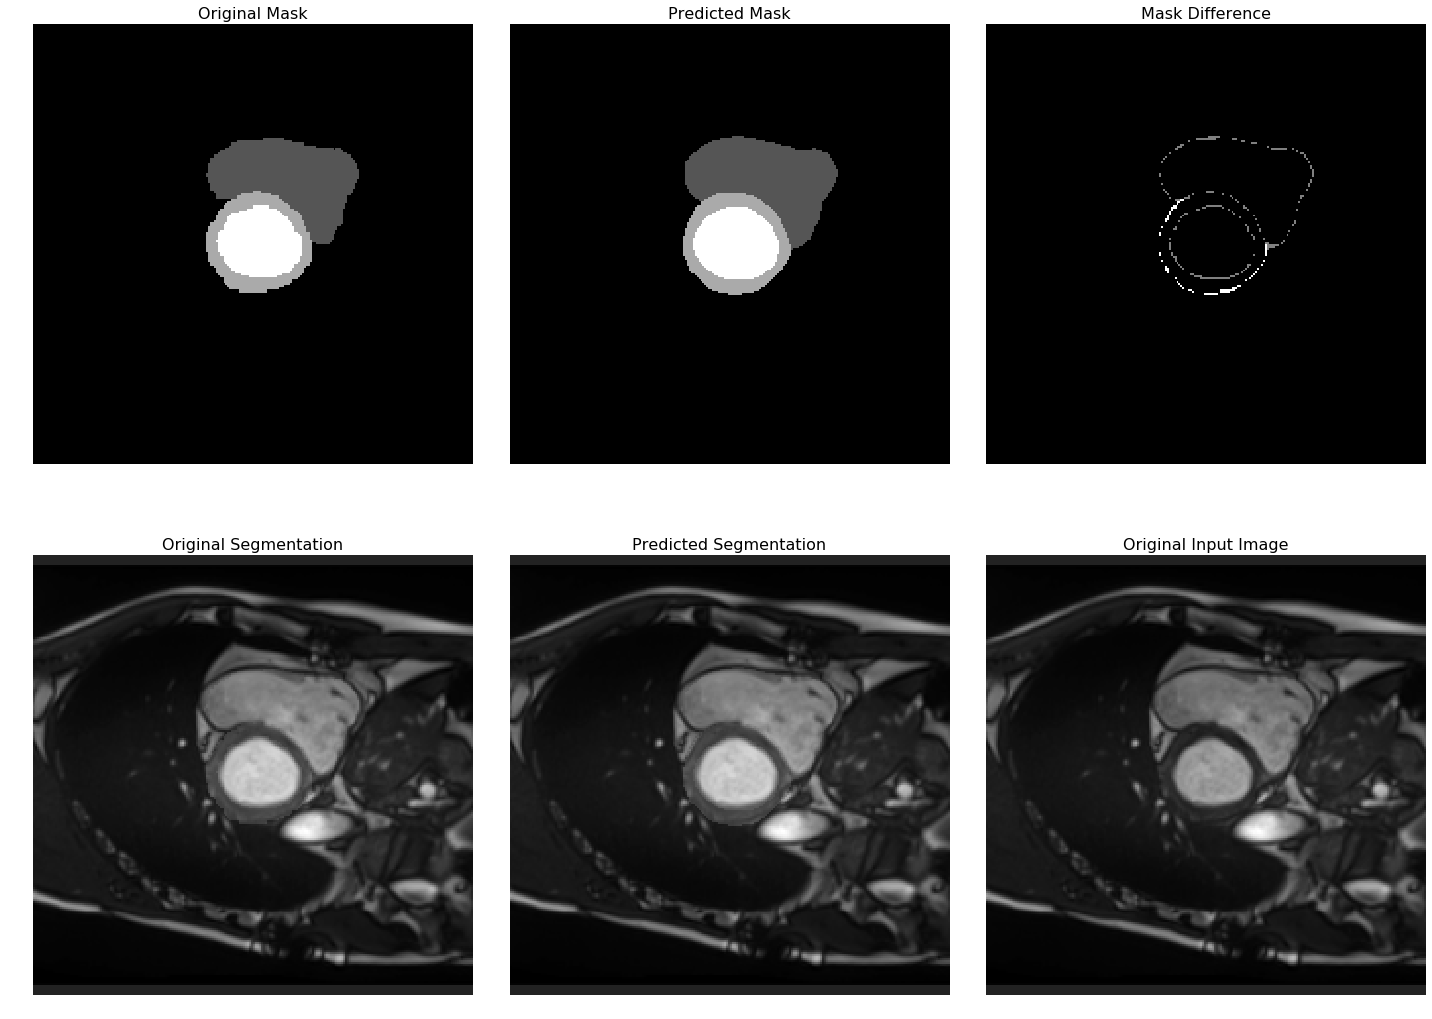

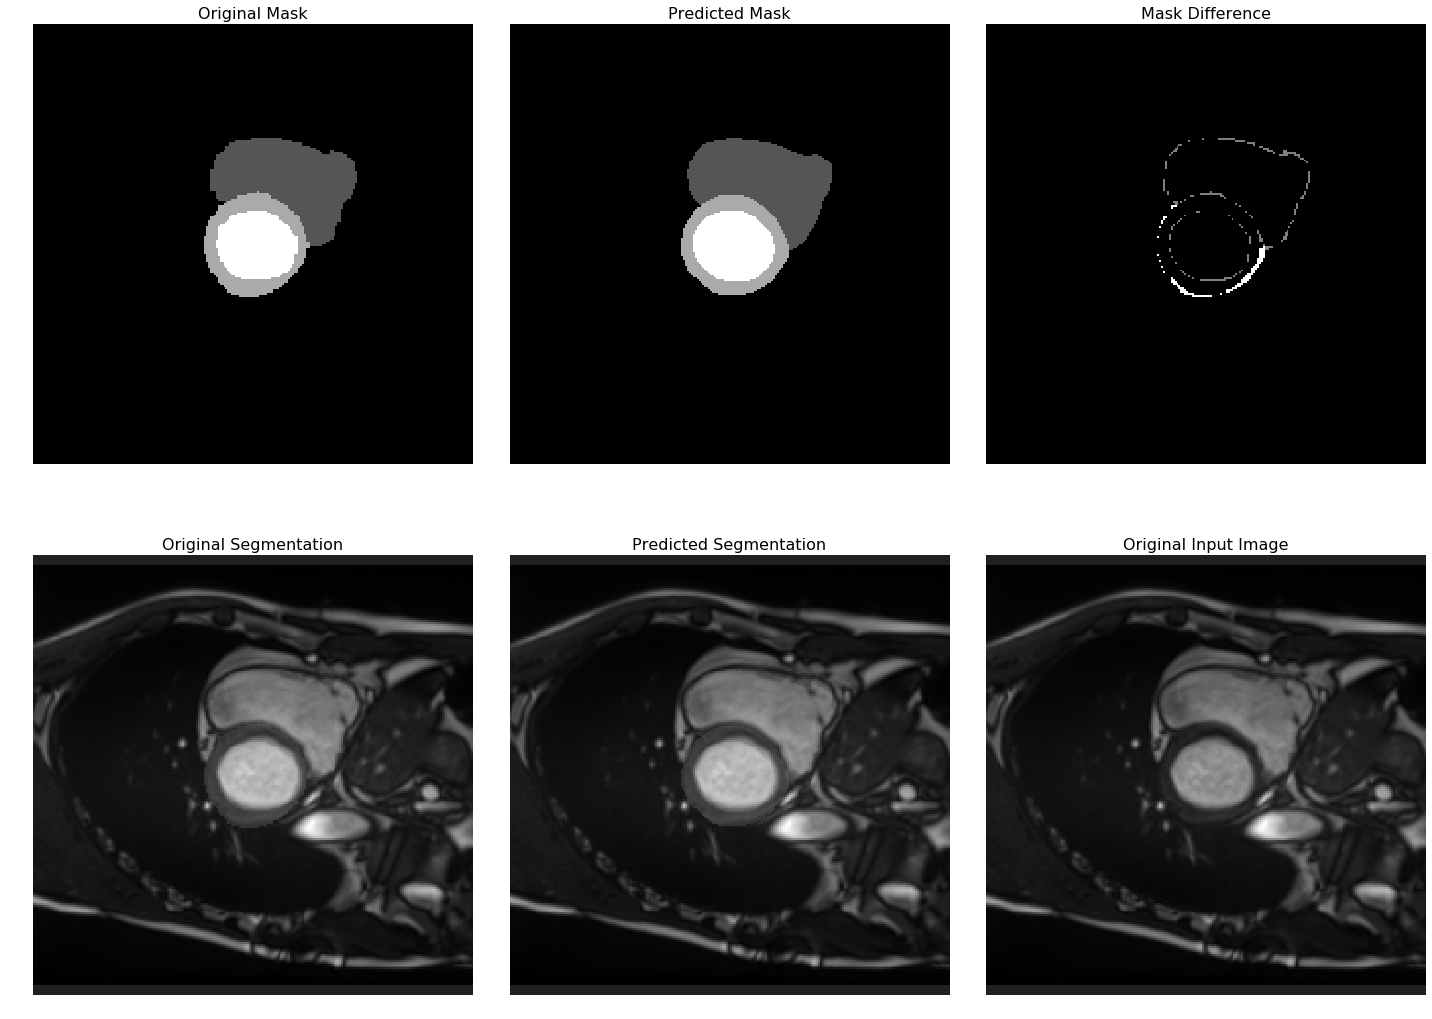

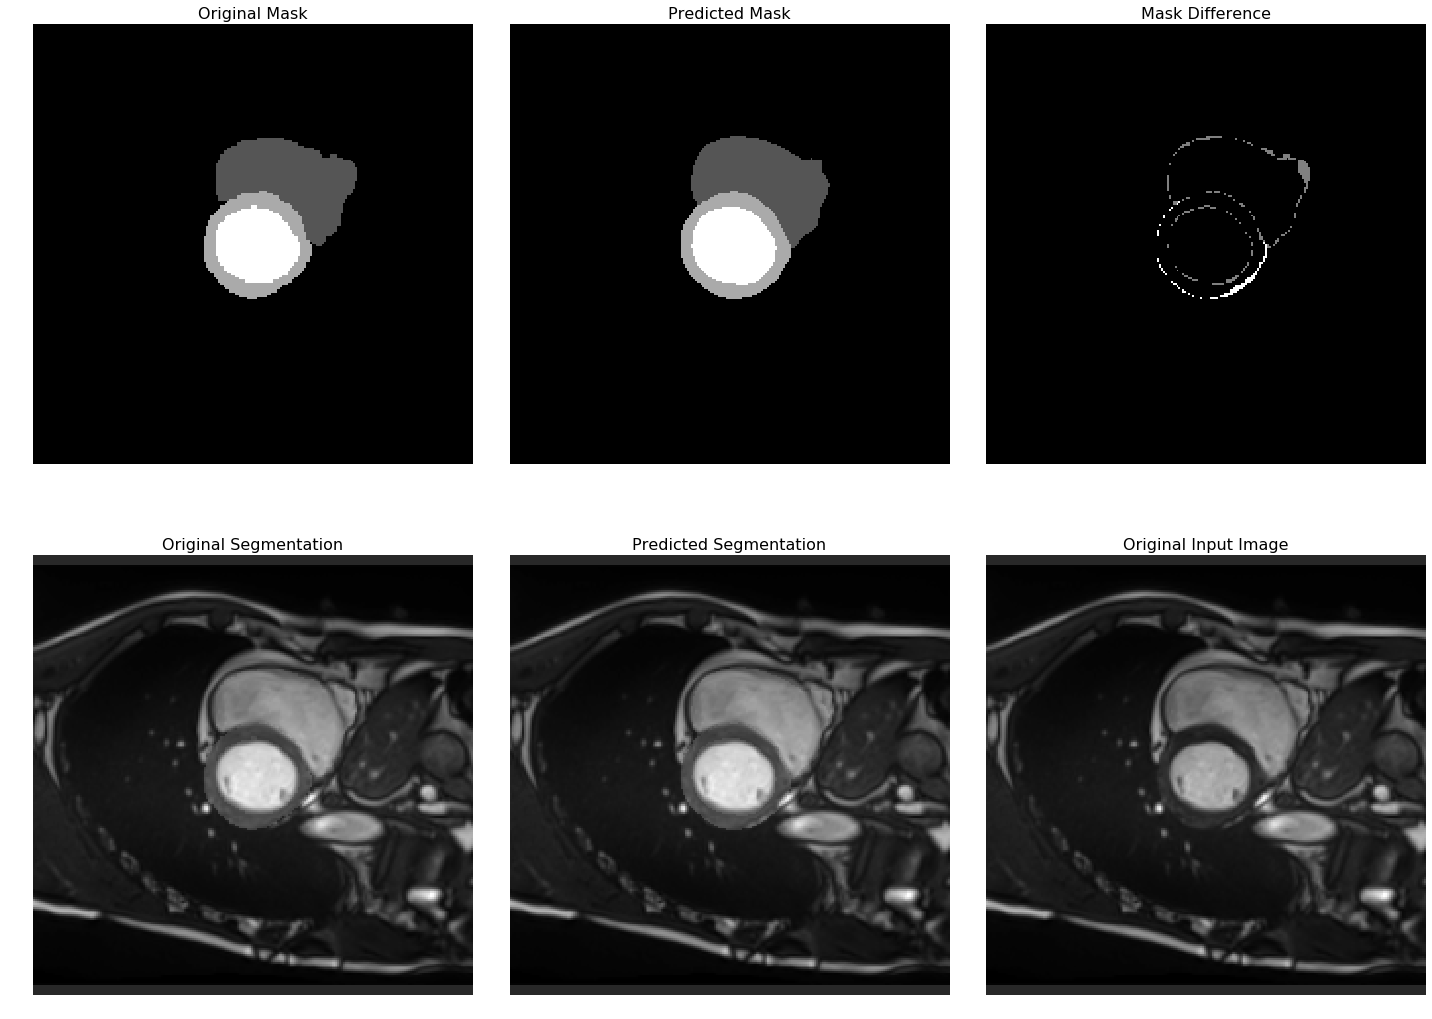

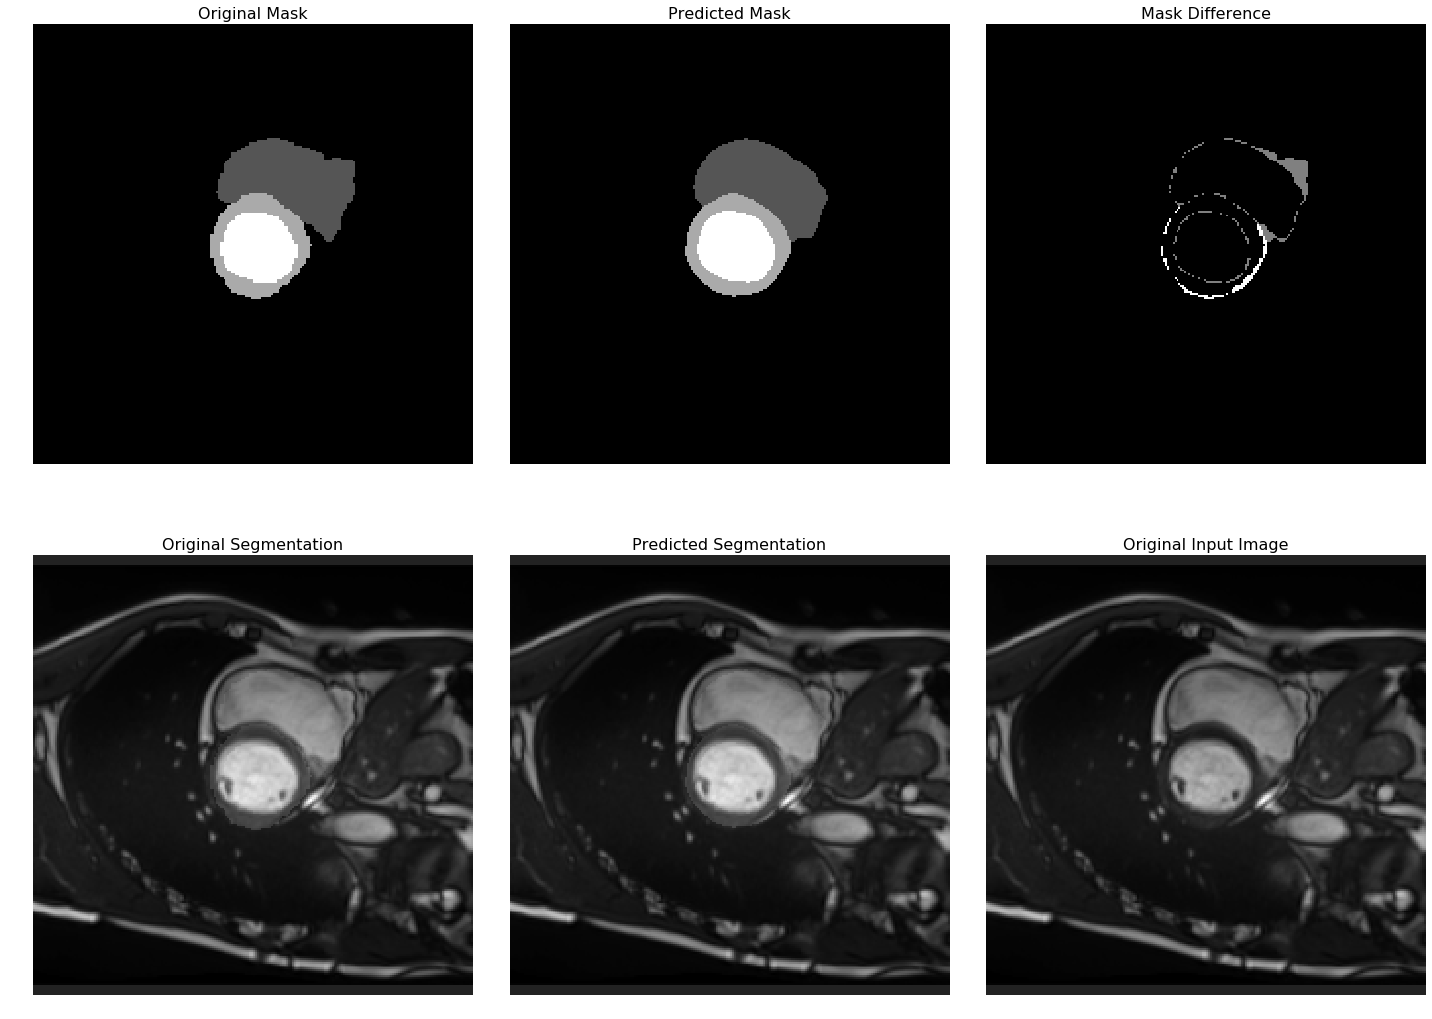

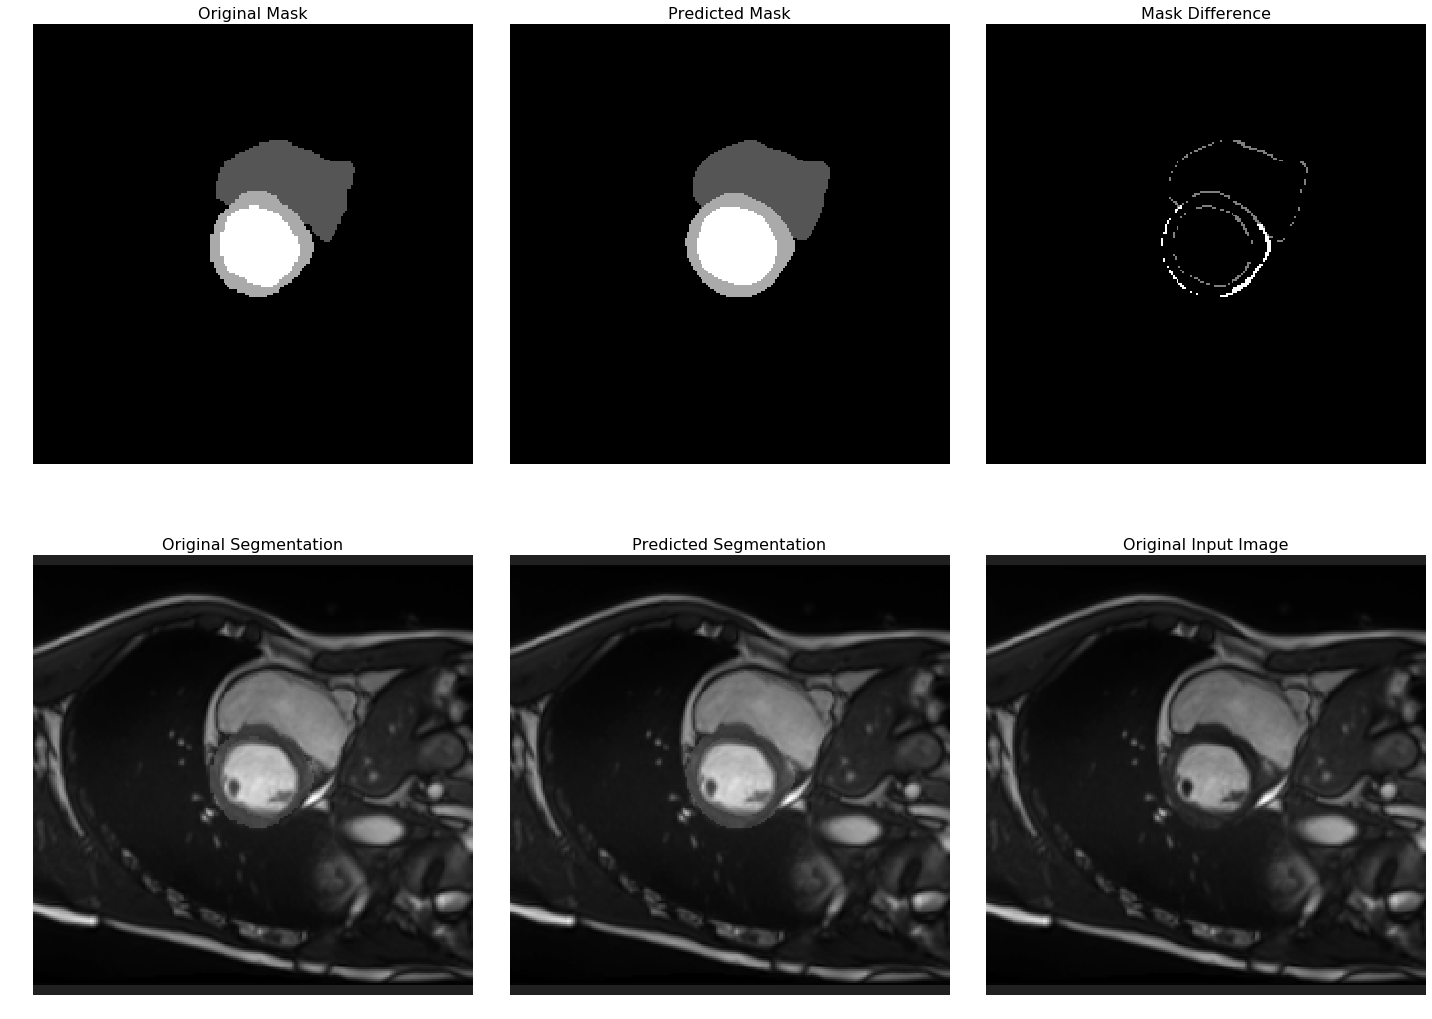

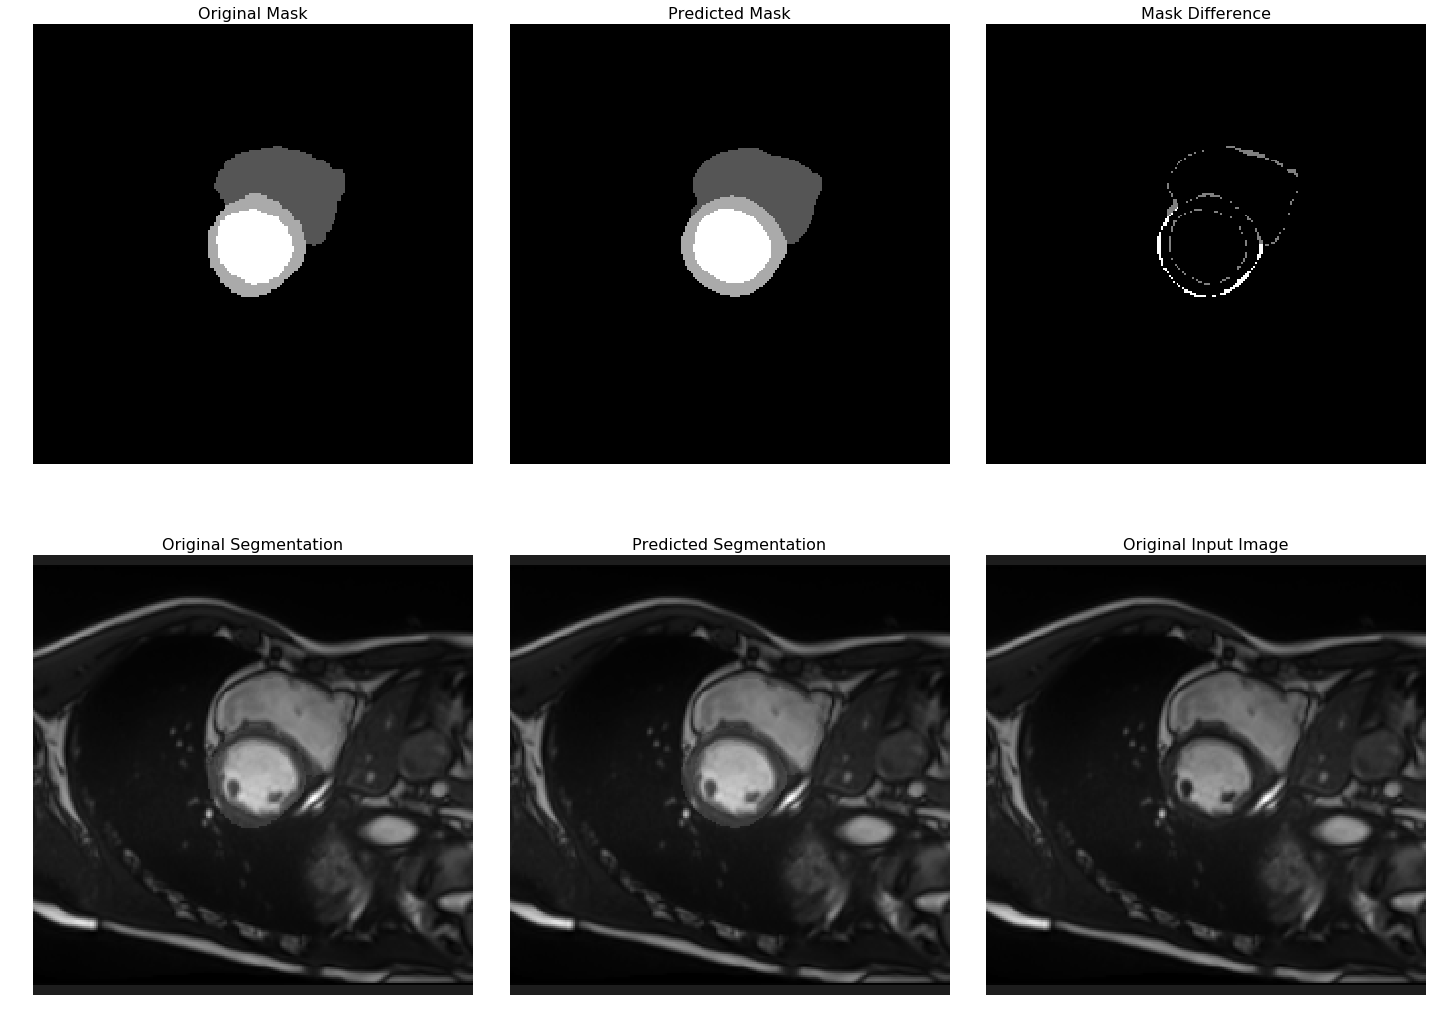

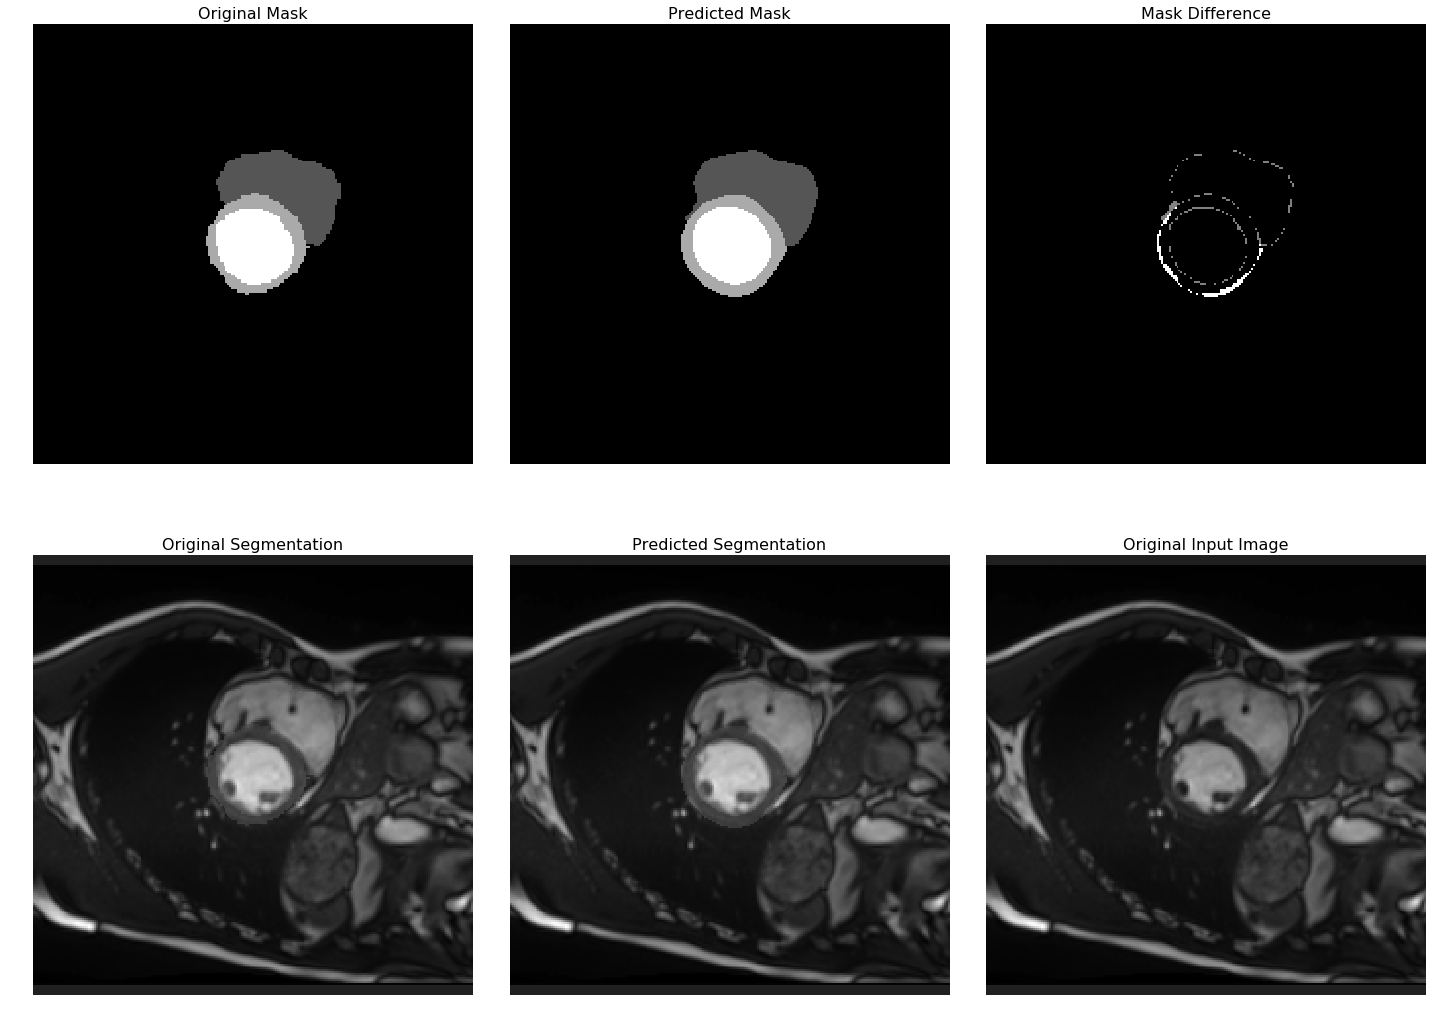

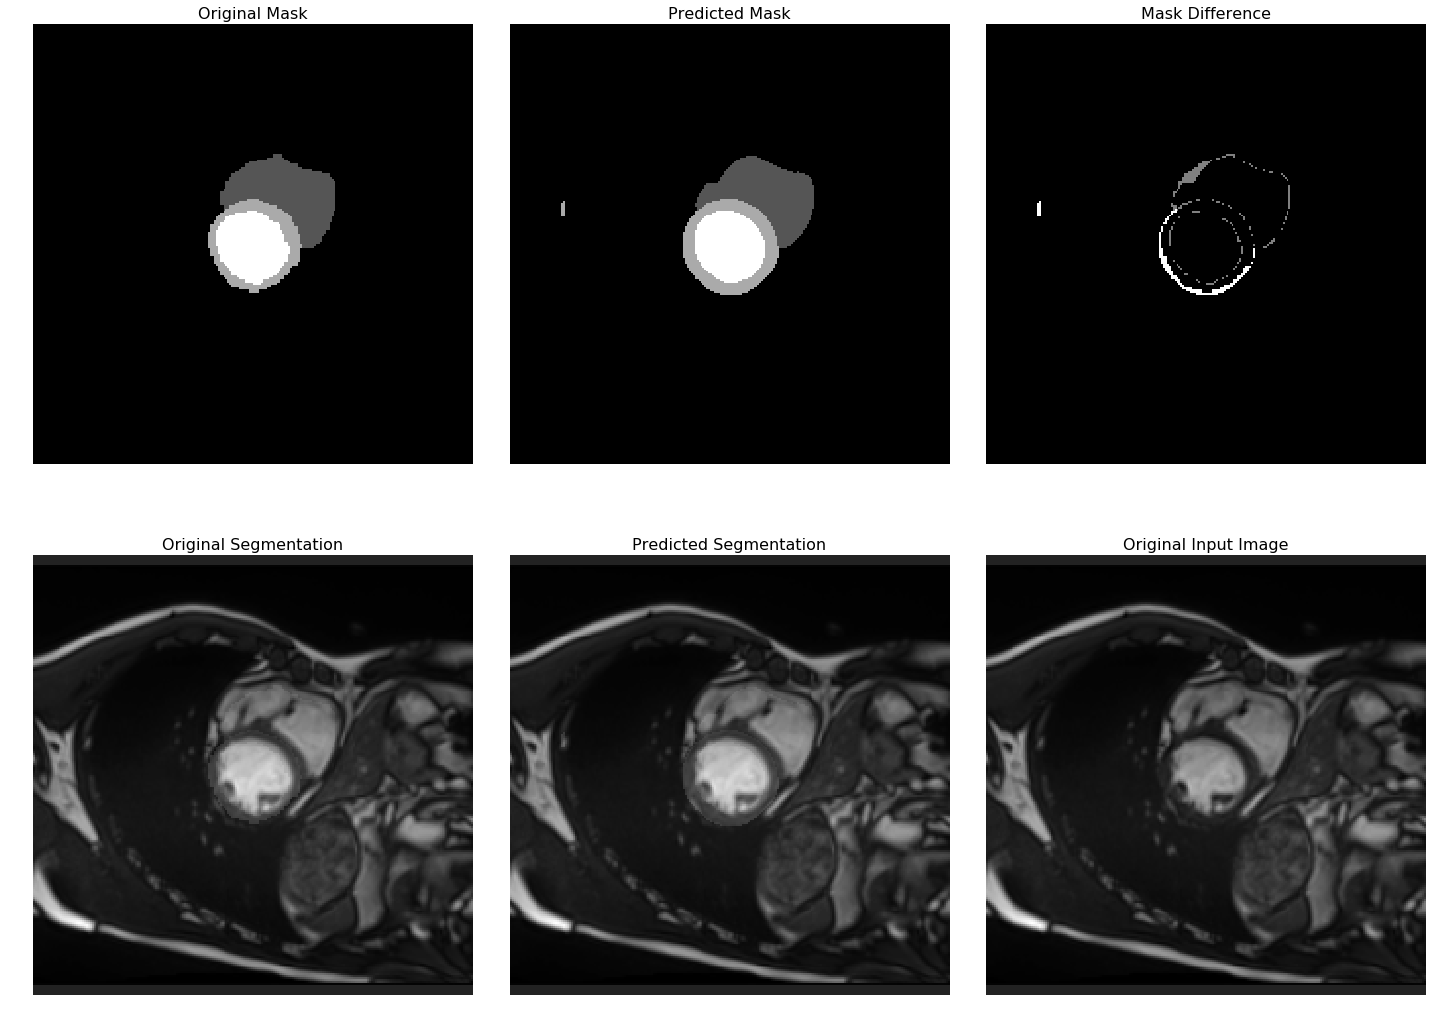

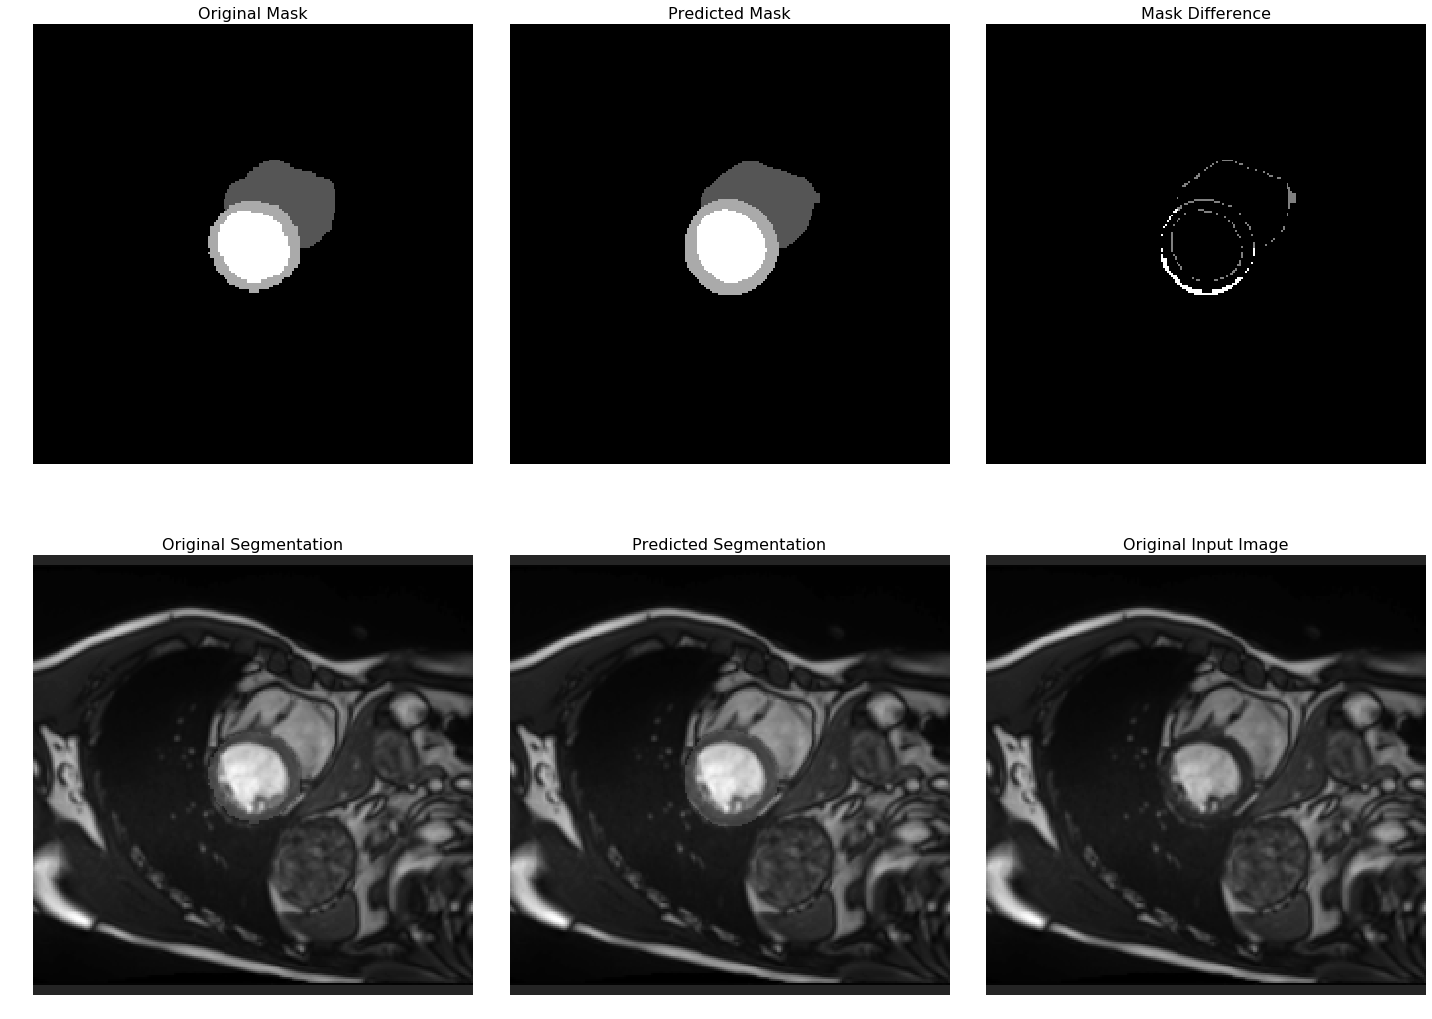

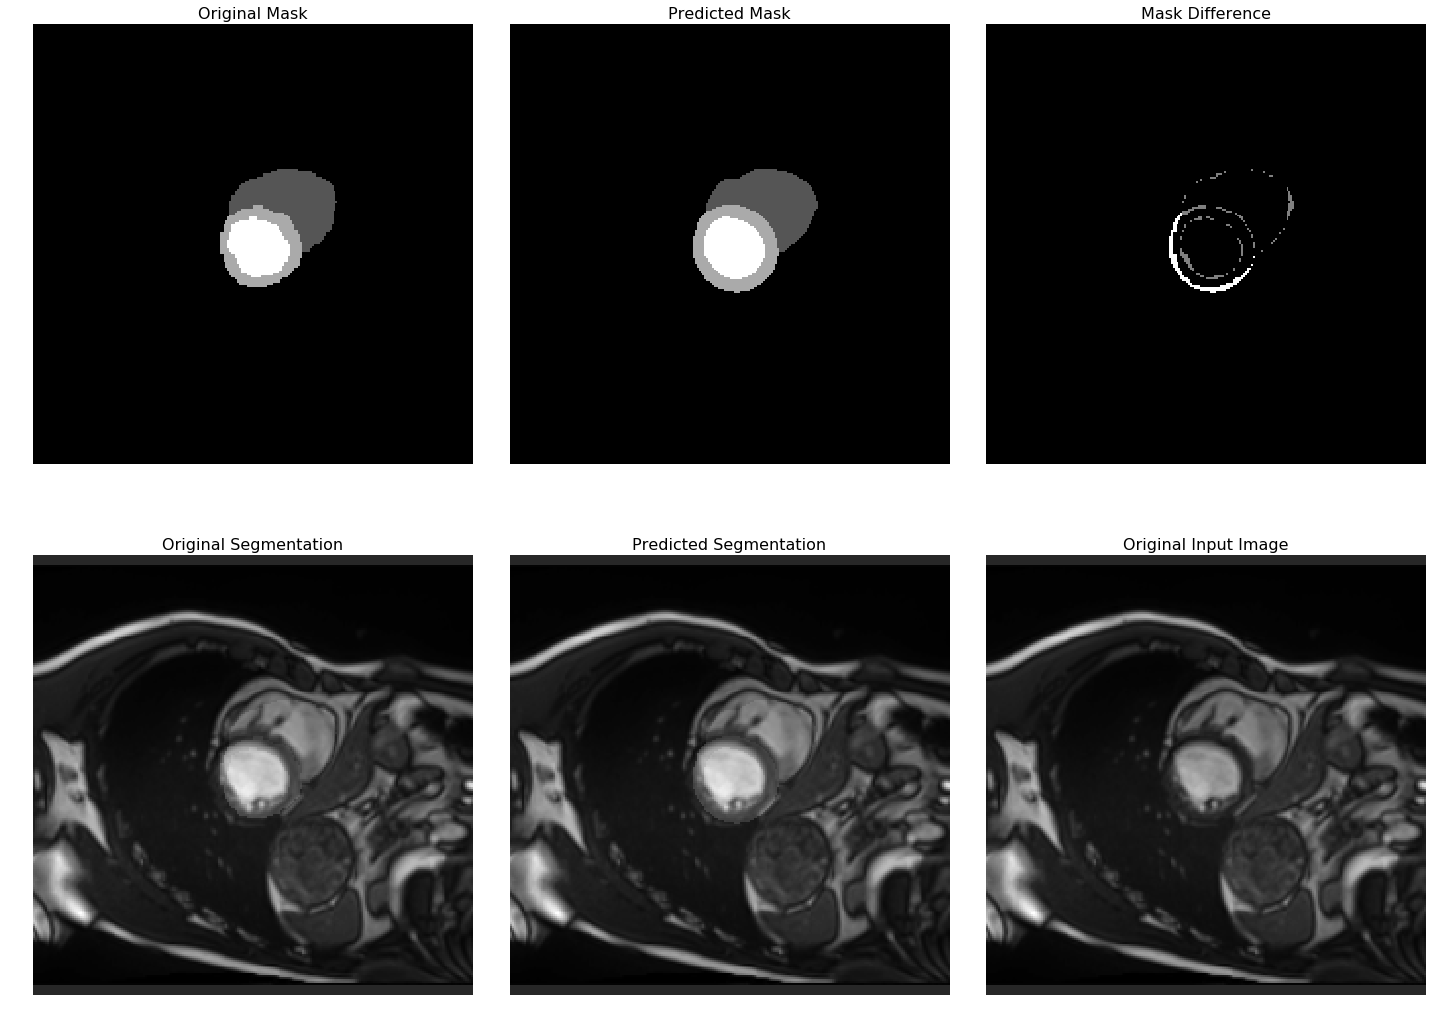

In [7]:
best_epoch=95;
unet_model = U_Net().to(device)
print('best epoch: ', best_epoch)
state_dict = torch.load('./saved_models/Mix/Basic_Unet_epoch_0%s.pth' % (best_epoch))
unet_model.load_state_dict(state_dict)
unet_model.eval();


for example_index in range(10):
    # The purpose of image_index is to make sure we truly pick from the test set.
    image_index = test_indices[example_index]
    sample = tumor_dataset[image_index]

    unet_model.eval()
    image2D = sample['image2D'].numpy()
    image3D = sample['image3D'].numpy()    
    mask = sample['mask2D'].numpy()

    image_tensor2D = torch.Tensor(image2D)
    image_tensor2D = image_tensor2D.view((1, 3, nx, nx)).to(device)
    image_tensor3D = torch.Tensor(image3D)
    image_tensor3D = image_tensor3D.view((1, 1, 3, nx, nx)).to(device)    
    output = unet_model(image_tensor2D, image_tensor3D).detach().cpu()
    output=F.softmax(output, dim=1)
    
    output = torch.max(output, 1)[1]
    output = output.numpy()
    
    image2D = np.resize(image2D, (nx, nx))
    mask = np.resize(mask, (nx, nx))
    output = np.resize(output, (nx, nx))
    d_score = pp.dice_coefficient(output, mask)
    title = f'Name: {image_index}.png'
    pp.plot_result(image2D, mask, output, title, save_path = None)
    